In [215]:
import numpy as np 
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler

In [216]:
df = pd.read_csv(r"C:\Users\vihaa\OneDrive\Desktop\INFOMATRIX\house_price\train (2).csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [217]:
df.shape

(1460, 81)

In [218]:
nan_columns = df.columns[df.isna().any()].tolist()
print(df[nan_columns].isna().sum())

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [219]:
mask = df.isna()

nan_groups = mask.T.groupby(list(mask.index)).groups

for pattern, cols in nan_groups.items():
    if mask.loc[:, list(cols)].any().any():
        print(list(cols))

['Electrical']
['MasVnrArea']
['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
['BsmtQual', 'BsmtCond', 'BsmtFinType1']
['BsmtExposure']
['BsmtFinType2']
['LotFrontage']
['MasVnrType']
['FireplaceQu']
['MiscFeature']
['Fence']
['Alley']
['PoolQC']


In [220]:
mask = df['MasVnrArea'].isna() & df['MasVnrType'].notna()
invalid_rows = df[mask]

print(f"Number of rows where MasVnrArea is NaN but MasVnrType is NOT NaN: {len(invalid_rows)}")
display(invalid_rows[['MasVnrArea', 'MasVnrType']])

Number of rows where MasVnrArea is NaN but MasVnrType is NOT NaN: 0


,MasVnrArea,MasVnrType


In [221]:
def initial_preprocessing(df):
    df = df.drop(columns = ['Id'])

    df['LotFrontage'] = df['LotFrontage'].fillna(0)
    #not all streets are connected to a public road, so I filled the NaN with 0.

    df['Alley'] = df['Alley'].map({'Grvl':1, 'Pave':2})
    df['Alley'] = df['Alley'].fillna(0)
    df.rename(columns={'Alley': 'Alley_O'}, inplace=True)

    df['MasVnrType'] = df['MasVnrType'].map({'BrkCmn':1, 'BrkFace':2,'Stone':3})
    df['MasVnrType'] = df['MasVnrType'].fillna(0)
    df['MasVnrArea'] = df['MasVnrArea'].fillna(0)
    #I noticed that if MasVnrType is NaN, MasVnrArea is also NaN. So I filled both with 0.
    #Also if more than 0 MasVnrArea, then MasVnrType is not NaN so, a new columns need to be made to capture that.
    df['HasMasVnr'] = (df['MasVnrArea'] > 0).astype(int)
    df.rename(columns={'MasVnrType': 'MasVnrType_O'}, inplace=True)
    df.rename(columns={'MasVnrArea': 'MasVnrArea_O'}, inplace=True)
    
    df['BsmtQual'] = df['BsmtQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
    df['BsmtQual'] = df['BsmtQual'].fillna(0)
    df.rename(columns={'BsmtQual': 'BsmtQual_O'}, inplace=True)
    df['BsmtCond'] = df['BsmtCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
    df['BsmtCond'] = df['BsmtCond'].fillna(0)
    df.rename(columns={'BsmtCond': 'BsmtCond_O'}, inplace=True)
    df['BsmntRec1'] = (df['BsmtFinType1'] == 'Rec').astype(int)
    df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ':4,'ALQ':3,'BLQ':2,'LwQ':1,'Unf':0})
    df['BsmtFinType1'] = df['BsmtFinType1'].fillna(0)
    df.rename(columns={'BsmtFinType1': 'BsmtFinType1_O'}, inplace=True)
    df['BsmtExposure'] = df['BsmtExposure'].map({'Gd':4,'Av':3,'Mn':2,'No':1})
    df['BsmtExposure'] = df['BsmtExposure'].fillna(0)
    df.rename(columns={'BsmtExposure': 'BsmtExposure_O'}, inplace=True)
    df['BsmntRec2'] = (df['BsmtFinType2'] == 'Rec').astype(int)
    df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ':4,'ALQ':3,'BLQ':2,'LwQ':1,'Unf':0})
    df['BsmtFinType2'] = df['BsmtFinType2'].fillna(0)
    df.rename(columns={'BsmtFinType2': 'BsmtFinType2_O'}, inplace=True)
    #Rec room is a room which has unknown quality, so I made a new column to capture that.

    df = df.dropna(subset=['Electrical'])
    #There is only one row with NaN in Electrical, so I dropped that row.
    df['Electrical'] = df['Electrical'].map({'SBrkr':5, 'Mix':4, 'FuseA':3, 'FuseF':2, 'FuseP':1})
    df.rename(columns={'Electrical': 'Electrical_O'}, inplace=True)

    df['FireplaceQu'] = df['FireplaceQu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
    df['FireplaceQu'] = df['FireplaceQu'].fillna(0)
    df.rename(columns={'FireplaceQu': 'FireplaceQu_O'}, inplace=True)

    df['TwoGarage'] = (df['GarageType'] == '2Types').astype(int)
    df['GarageType'] = df['GarageType'].map({'BuiltIn':5,'Attchd':4,'Detchd':3,'CarPort':2,'Basment':1})
    df['GarageType'] = df['GarageType'].fillna(0)
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)
    df['GarageFinish'] = df['GarageFinish'].map({'Fin':3,'RFn':2,'Unf':1})
    df['GarageFinish'] = df['GarageFinish'].fillna(0)
    df['GarageQual'] = df['GarageQual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
    df['GarageQual'] = df['GarageQual'].fillna(0)
    df['GarageCond'] = df['GarageCond'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
    df['GarageCond'] = df['GarageCond'].fillna(0)
    df.rename(columns = {'GarageQual': 'GarageQual_O'}, inplace=True)
    df.rename(columns = {'GarageCond': 'GarageCond_O'}, inplace=True)

    df['PoolQC'] = df['PoolQC'].map({'Ex':3,'Gd':2,'Fa':1})
    df['PoolQC'] = df['PoolQC'].fillna(0)

    df['Fence'] = df['Fence'].map({'GdPrv':4,'GdWo':3,'MnPrv':2,'MnWw':1})
    df['Fence'] = df['Fence'].fillna(0)

    df['MiscFeature'] = df['MiscFeature'].notna().astype(int)
    #there are low number of houses with MiscFeature so I made it binary.

    df = df[[col for col in df.columns if col != 'SalePrice'] + ['SalePrice']]

    return df

df_ip = initial_preprocessing(df)
df_ip.shape

(1459, 84)

In [222]:
categorical_cols = df_ip.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [223]:
df['SaleType'].value_counts()

SaleType
WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: count, dtype: int64

In [224]:
def post_preprocessing(df):

    df = pd.get_dummies(df, columns=['MSZoning'], prefix='Zone', drop_first=True)
    dummy_cols = [col for col in df.columns if col.startswith("Zone_")]
    df[dummy_cols] = df[dummy_cols].astype(int)

    df['Street'] = df['Street'].map({'Pave':2, 'Grvl':1})

    df['LotShape'] = df['LotShape'].map({'Reg':4,'IR1':3,'IR2':2,'IR3':1})

    df['LandContour'] = df['LandContour'].map({'Lvl':4,'Bnk':3,'HLS':2,'Low':1})

    df = df.drop(columns=['Utilities'])
    #All the houses have 'AllPub' except one house

    df['LotConfigQuiet'] = df['LotConfig'].map({'CulDSac':3,'Inside':2,'Corner':1,'FR2':1,'FR3':1})
    #Some people prefer quiet locations, so I made a new column to capture that.
    df['LotConfig'] = df['LotConfig'].replace({'FR3': 'FR2'})
    df = pd.get_dummies(df, columns=['LotConfig'], prefix='Lot', drop_first=True)
    #I dont know what people prefer more, corner or inside, so I made dummies for both.

    df['LandSlope'] = df['LandSlope'].map({'Gtl':3,'Mod':2,'Sev':1})

    mapping = {
    'NoRidge': 3,
    'NridgHt': 3,
    'StoneBr': 3,
    'Veenker': 3,
    'Somerst': 3,
    'CollgCr': 2,
    'Gilbert': 2,
    'Crawfor': 2,
    'Blmngtn': 2,
    'ClearCr': 2,
    'Timber': 2,
    'SawyerW': 2,
    'NWAmes': 2,
    'Sawyer': 2,
    'Mitchel': 2,
    'NAmes': 1,
    'OldTown': 1,
    'Edwards': 1,
    'BrkSide': 1,
    'SWISU': 1,
    'MeadowV': 1,
    'BrDale': 1,
    'IDOTRR': 1,
    'NPkVill': 1,
    'Blueste': 1
    }
    df['Neighborhood'] = df['Neighborhood'].replace(mapping)

    mapping = {
    'Norm': 'Normal',
    'Feedr': 'Traffic',
    'Artery': 'Traffic',
    'RRAn': 'Railroad',
    'RRAe': 'Railroad',
    'RRNn': 'Railroad',
    'RRNe': 'Railroad',
    'PosN': 'Positive',
    'PosA': 'Positive'
    }

    df['Condition1'] = df['Condition1'].replace(mapping)
    df = pd.get_dummies(df, columns=['Condition1'], prefix='Cond1', drop_first=True)

    df['HasCondition2'] = (df['Condition2'] != 'Norm').astype(int)
    df = df.drop(columns=['Condition2'])

    df['Bldg_SingleFam'] = (df['BldgType'] == '1Fam').astype(int)
    df['Bldg_Townhouse'] = df['BldgType'].map({'TwnhsE': 2,'Twnhs': 1}).fillna(0).astype(int)
    df['Bldg_MultiFamily'] = df['BldgType'].map({'Duplex': 2,'2fmCon': 1}).fillna(0).astype(int)
    df = df.drop(columns=['BldgType'])

    house_style_map = {
    '2Story': 4,
    '2.5Fin': 4,
    '2.5Unf': 4,
    '1.5Fin': 3,
    '1.5Unf': 2,
    'SLvl': 2,
    'SFoyer': 2,
    '1Story': 1
    }
    df['HouseStyle'] = df['HouseStyle'].map(house_style_map)

    df['Roof_Common'] = (df['RoofStyle'] == 'Gable').astype(int)
    df['Roof_Uncommon'] = (df['RoofStyle'] == 'Hip').astype(int)
    df['Roof_Rare'] = (~df['RoofStyle'].isin(['Gable', 'Hip'])).astype(int)
    df = df.drop(columns=['RoofStyle'])

    df['RoofMatl'] = (df['RoofMatl'] == 'CompShg').astype(int)
    #Most common roof material is CompShg, so I made a binary column to capture that.

    valid_categories = df['Exterior1st'].unique()
    df = df[df['Exterior2nd'].isin(valid_categories)]
    # I noticed that Exterior2nd has some categories which are not in Exterior1st, so I removed those rows.
    exterior_map = {
    'BrkFace': 3, 'BrkComm': 3, 'Stone': 3, 'CemntBd': 3,
    'VinylSd': 2, 'MetalSd': 2, 'Stucco': 2, 'Plywood': 2, 'HdBoard': 2,
    'Wd Sdng': 1, 'WdShing': 1, 'AsbShng': 1, 'AsphShn': 1, 'ImStucc': 1, 'CBlock': 1
    }
    df['Exterior1st'] = df['Exterior1st'].map(exterior_map)
    df['Exterior2nd'] = df['Exterior2nd'].map(exterior_map)

    df['ExterQual'] = df['ExterQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1})
    df['ExterCond'] = df['ExterCond'].map({'Ex':3,'Gd':3,'TA':2,'Fa':1,'Po':1})

    foundation_map = {
    'PConc': 4,
    'CBlock': 3,
    'BrkTil': 2,
    'Slab': 1,
    'Stone': 1,
    'Wood': 1
    }
    df['Foundation'] = df['Foundation'].map(foundation_map)

    df['Heating'] = (df['Heating'] == 'GasA').astype(int)
    #Most common heating type is GasA, so I made a binary column to capture that.

    df['HeatingQC'] = df['HeatingQC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':1})

    df['CentralAir'] = df['CentralAir'].map({'Y':1,'N':0})

    df['KitchenQual'] = df['KitchenQual'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1})

    df['Functional'] = df['Functional'].map({'Typ':3,'Min1':2,'Min2':2,'Mod':1,'Maj1':1,'Maj2':1,'Sev':1})

    df['PavedDrive'] = (df['PavedDrive'] == 'Y').astype(int)
    #Most of the houses have PavedDrive as 'Y', so I made it binary.

    df['SaleType'] = df['SaleType'].map({'WD':5,'New':4,'COD':3,'ConLD':2,'ConLI':2,'CWD':2,'Oth':1,'ConLw':1})

    sale_type_map = {
    'WD': 3,
    'New': 2
    }
    df['SaleType'] = df['SaleType'].map(lambda x: sale_type_map.get(x, 1))

    sale_condition_map = {
    'Normal': 3,
    'Partial': 2
    }
    df['SaleCondition'] = df['SaleCondition'].map(lambda x: sale_condition_map.get(x, 1))

    df = df[[col for col in df.columns if col != 'SalePrice'] + ['SalePrice']]

    return df

df_pp = post_preprocessing(df_ip)
df_pp.shape

C:\Users\vihaa\AppData\Local\Temp\ipykernel_108072\41137310.py:51: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



(1353, 95)

In [225]:
nan_columns = df_pp.columns[df_pp.isna().any()].tolist()
print(df_pp[nan_columns].isna().sum())

Series([], dtype: float64)


In [226]:
corr = df_pp.corr(method="spearman", numeric_only=True)
fig = px.imshow(corr, 
                text_auto=".2f", 
                color_continuous_scale="RdBu_r",
                title="Spearman Correlation Heatmap of df_pp")

fig.update_layout(width=1200, height=1000)  
fig.write_html("spearman_heatmap.html")

In [227]:
X = df_pp.drop(columns=['SalePrice'])
y = df_pp['SalePrice']
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [228]:
rmse_scores = []
predictions_per_fold = []
actuals_per_fold = []
models_per_fold = []

# Linear Regression

In [229]:
lr = LinearRegression()

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_val)
    
    rmse_val = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append(rmse_val)
    
    predictions_per_fold.append(y_pred)
    actuals_per_fold.append(y_val.values)
    models_per_fold.append(lr) 

best_fold_index = np.argmin(rmse_scores)      
best_y_pred = predictions_per_fold[best_fold_index]   
best_y_actual = actuals_per_fold[best_fold_index]     
best_lr_model = models_per_fold[best_fold_index]
print("Best Rmse : ", rmse_scores[best_fold_index]) 


Best Rmse :  27261.132160004276


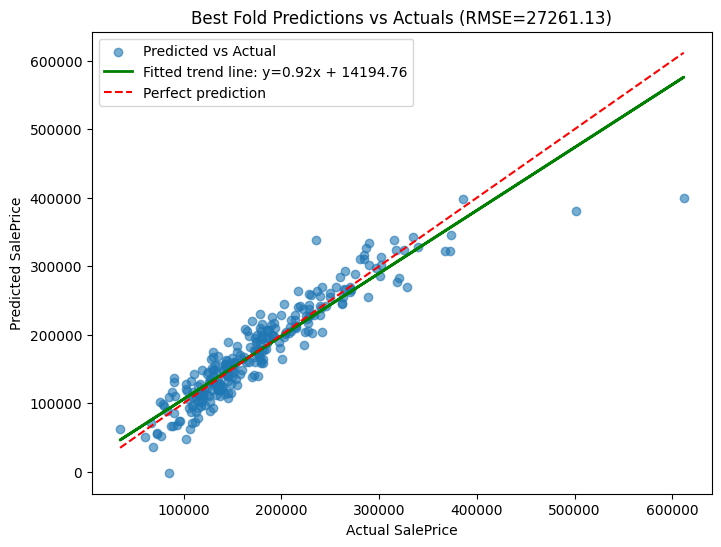

In [230]:
coef = np.polyfit(best_y_actual, best_y_pred, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(8,6))
plt.scatter(best_y_actual, best_y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot(best_y_actual, poly1d_fn(best_y_actual), color='green', linewidth=2, label=f'Fitted trend line: y={coef[0]:.2f}x + {coef[1]:.2f}')
plt.plot([min(best_y_actual), max(best_y_actual)], [min(best_y_actual), max(best_y_actual)], color='red', linestyle='--', label='Perfect prediction')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Best Fold Predictions vs Actuals (RMSE={rmse_scores[best_fold_index]:.2f})")
plt.legend()
plt.show()

# Ridge Regression

In [231]:
rmse_scores = []
predictions_per_fold = []
actuals_per_fold = []
models_per_fold = []

In [232]:
rr = Ridge(alpha=1.0)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    rr.fit(X_train, y_train)
    y_pred = rr.predict(X_val)
    
    rmse_val = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append(rmse_val)
    
    predictions_per_fold.append(y_pred)
    actuals_per_fold.append(y_val.values)
    models_per_fold.append(rr) 

best_fold_index = np.argmin(rmse_scores)      
best_y_pred = predictions_per_fold[best_fold_index]   
best_y_actual = actuals_per_fold[best_fold_index]     
best_rr_model = models_per_fold[best_fold_index]
print("Best Rmse : ", rmse_scores[best_fold_index])    


Best Rmse :  26720.92995722062


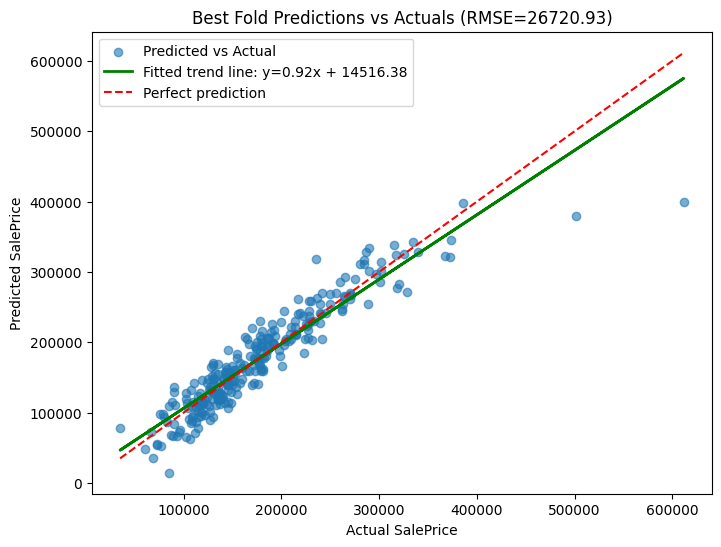

In [233]:
coef = np.polyfit(best_y_actual, best_y_pred, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(8,6))
plt.scatter(best_y_actual, best_y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot(best_y_actual, poly1d_fn(best_y_actual), color='green', linewidth=2, label=f'Fitted trend line: y={coef[0]:.2f}x + {coef[1]:.2f}')
plt.plot([min(best_y_actual), max(best_y_actual)], [min(best_y_actual), max(best_y_actual)], color='red', linestyle='--', label='Perfect prediction')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Best Fold Predictions vs Actuals (RMSE={rmse_scores[best_fold_index]:.2f})")
plt.legend()
plt.show()

# Lasso 

In [234]:
rmse_scores = []
predictions_per_fold = []
actuals_per_fold = []
models_per_fold = []

In [235]:
llr = Lasso(alpha=1.0, max_iter=1000000)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    llr.fit(X_train, y_train)
    y_pred = llr.predict(X_val)
    
    rmse_val = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append(rmse_val)
    
    predictions_per_fold.append(y_pred)
    actuals_per_fold.append(y_val.values)
    models_per_fold.append(llr) 

best_fold_index = np.argmin(rmse_scores)      
best_y_pred = predictions_per_fold[best_fold_index]   
best_y_actual = actuals_per_fold[best_fold_index]     
best_llr_model = models_per_fold[best_fold_index]
print("Best Rmse : ", rmse_scores[best_fold_index])   


Best Rmse :  27234.5989929452


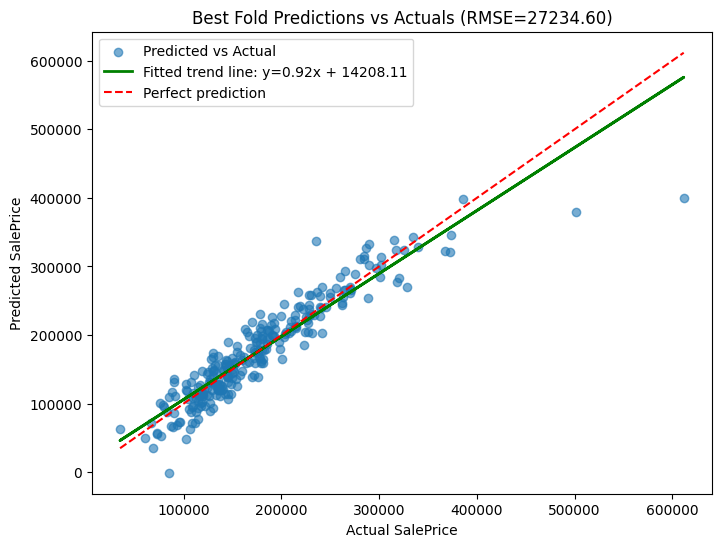

In [236]:
coef = np.polyfit(best_y_actual, best_y_pred, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(8,6))
plt.scatter(best_y_actual, best_y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot(best_y_actual, poly1d_fn(best_y_actual), color='green', linewidth=2, label=f'Fitted trend line: y={coef[0]:.2f}x + {coef[1]:.2f}')
plt.plot([min(best_y_actual), max(best_y_actual)], [min(best_y_actual), max(best_y_actual)], color='red', linestyle='--', label='Perfect prediction')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Best Fold Predictions vs Actuals (RMSE={rmse_scores[best_fold_index]:.2f})")
plt.legend()
plt.show()

In [ ]:
def feature_engineering(df):
    cols_to_invert = [col for col in df.columns if col.endswith('_O')]
    for col in cols_to_invert:
        df[col + '_inverted'] = 1 / (df[col] + 0.0001)
    df['LotArea_Frontage'] = df['LotArea'] * df['LotFrontage']
    df['QuietSlope'] = df['LandSlope'] * df['LotConfigQuiet']
    df['feature1'] = (df['OverallQual'] **2) * df['GrLivArea']
    df['feature2'] = (df['Neighborhood'] **3) * df['ExterQual']
    df['feature3'] = (df['BsmtQual_O'] **3) * df['Foundation']
    return df
df_fe = feature_engineering(df_pp)
df_fe.shape

(1353, 111)

In [238]:
X = df_fe.drop(columns=['SalePrice'])
y = df_fe['SalePrice']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [239]:
rmse_scores = []
predictions_per_fold = []
actuals_per_fold = []
models_per_fold = []

In [240]:
rr = Ridge(alpha=1.0)

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    rr.fit(X_train, y_train)
    y_pred = rr.predict(X_val)
    
    rmse_val = root_mean_squared_error(y_val, y_pred)
    rmse_scores.append(rmse_val)
    
    predictions_per_fold.append(y_pred)
    actuals_per_fold.append(y_val.values)
    models_per_fold.append(rr) 

best_fold_index = np.argmin(rmse_scores)      
best_y_pred = predictions_per_fold[best_fold_index]   
best_y_actual = actuals_per_fold[best_fold_index]     
best_rr_model = models_per_fold[best_fold_index]
print("Best Rmse : ", rmse_scores[best_fold_index])    


Best Rmse :  24764.642291436823


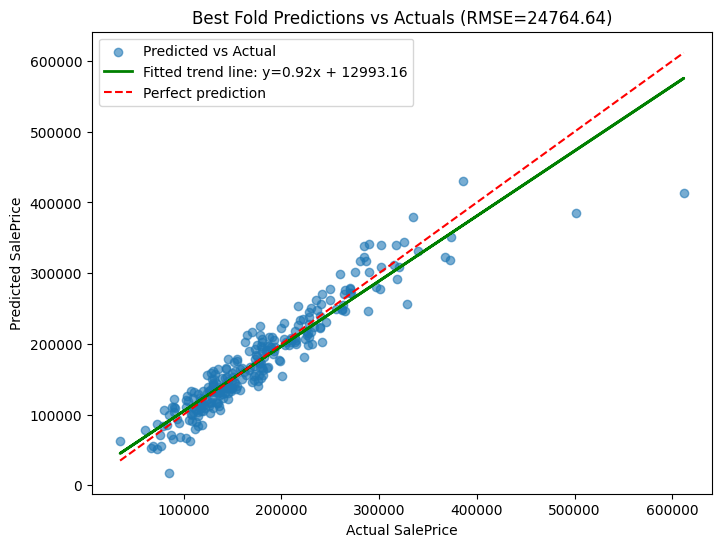

In [241]:
coef = np.polyfit(best_y_actual, best_y_pred, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(8,6))
plt.scatter(best_y_actual, best_y_pred, alpha=0.6, label='Predicted vs Actual')
plt.plot(best_y_actual, poly1d_fn(best_y_actual), color='green', linewidth=2, label=f'Fitted trend line: y={coef[0]:.2f}x + {coef[1]:.2f}')
plt.plot([min(best_y_actual), max(best_y_actual)], [min(best_y_actual), max(best_y_actual)], color='red', linestyle='--', label='Perfect prediction')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title(f"Best Fold Predictions vs Actuals (RMSE={rmse_scores[best_fold_index]:.2f})")
plt.legend()
plt.show()